In [1]:
import cv2
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.12.0


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image                

%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
assignment_path = r"G:\Semester 10\CVPR\assignment_1"
os.chdir(assignment_path)
print("Current Directory:", os.getcwd())

Current Directory: G:\Semester 10\CVPR\assignment_1


In [4]:
files = os.listdir()
images = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]
print("Images in folder:", images)


Images in folder: []


In [22]:
import os
import cv2
import matplotlib.pyplot as plt


dataset_path = r"G:\Semester 10\CVPR\assignment_1\animal_dataset"

images_dict = {}

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
       
        img_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
        images_dict[class_name] = [os.path.join(class_folder, f) for f in img_files]

for class_name, files in images_dict.items():
    print(f"{class_name}: {len(files)} images")

cat: 100 images
dog: 100 images
panda: 100 images


In [25]:
import os
import numpy as np
from PIL import Image

DATASET_DIR = r"G:\Semester 10\CVPR\assignment_1\animal_dataset"
IMAGE_SIZE = (32, 32)

def load_dataset(root_dir, image_size=(32, 32)):
    X = []
    y = []
    label_map = {}
    
    class_folders = [
        d for d in sorted(os.listdir(root_dir))
        if os.path.isdir(os.path.join(root_dir, d))
    ]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")
    
    for label, class_name in enumerate(class_folders):
        class_dir = os.path.join(root_dir, class_name)
        label_map[label] = class_name
        
        img_files = [
            fname for fname in os.listdir(class_dir)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]
        
        print(f"  Processing {class_name}: {len(img_files)} images")
        
        for fname in img_files:
            img_path = os.path.join(class_dir, fname)
            img = Image.open(img_path).convert('L')
            img = img.resize(image_size)
            img_np = np.array(img, dtype=np.float32) / 255.0
            img_flat = img_np.flatten()
            
            X.append(img_flat)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nDataset Loaded: {X.shape} {y.shape}")
    return X, y, label_map

X, y, label_map = load_dataset(DATASET_DIR, IMAGE_SIZE)


Found 3 classes: ['cat', 'dog', 'panda']
  Processing cat: 100 images
  Processing dog: 100 images
  Processing panda: 100 images

Dataset Loaded: (300, 1024) (300,)


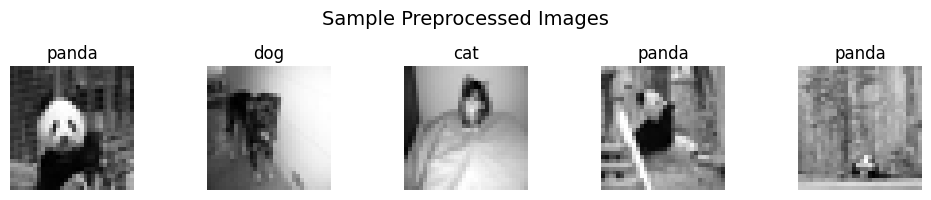

In [26]:
np.random.seed(0)
idxs = np.random.choice(len(X), size=5, replace=False)

plt.figure(figsize=(10, 2))
for i, idx in enumerate(idxs):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[idx].reshape(IMAGE_SIZE), cmap='gray')
    plt.title(label_map[y[idx]])
    plt.axis('off')
plt.suptitle("Sample Preprocessed Images", fontsize=14)
plt.tight_layout()
plt.show()

In [27]:

def l1_distance(x, X_train):

    return np.sum(np.abs(X_train - x), axis=1)


def l2_distance(x, X_train):

    return np.sqrt(np.sum((X_train - x) ** 2, axis=1))


In [28]:
np.random.seed(1)
idx_a, idx_b = np.random.choice(len(X), size=2, replace=False)

x_a = X[idx_a]
x_b = X[idx_b]

l1_ab = l1_distance(x_a, X[[idx_b]])[0]
l2_ab = l2_distance(x_a, X[[idx_b]])[0]

print(f"Comparing sample {idx_a} (label={label_map[y[idx_a]]}) "
      f"and sample {idx_b} (label={label_map[y[idx_b]]}):")
print(f"  L1 distance = {l1_ab:.6f}")
print(f"  L2 distance = {l2_ab:.6f}")

Comparing sample 189 (label=dog) and sample 123 (label=dog):
  L1 distance = 237.521576
  L2 distance = 8.516315


In [29]:
def knn_predict(X_train, y_train, X_test, k=3, distance_type='l2'):


    y_pred = []

    for i in range(X_test.shape[0]):
        x = X_test[i]

                   
        if distance_type == 'l1':
            dists = l1_distance(x, X_train)
        elif distance_type == 'l2':
            dists = l2_distance(x, X_train)
        else:
            raise ValueError("distance_type must be 'l1' or 'l2'")

                                        
        nn_indices = np.argsort(dists)[:k]

                                     
        nn_labels = y_train[nn_indices]

                       
        values, counts = np.unique(nn_labels, return_counts=True)
        majority_label = values[np.argmax(counts)]
        y_pred.append(majority_label)

    return np.array(y_pred)


In [30]:
def knn_predict_weighted(X_train, y_train, X_test, k=3, distance_type='l2'):

    eps = 1e-8
    y_pred = []

    for i in range(X_test.shape[0]):
        x = X_test[i]

        if distance_type == 'l1':
            dists = l1_distance(x, X_train)
        elif distance_type == 'l2':
            dists = l2_distance(x, X_train)
        else:
            raise ValueError("distance_type must be 'l1' or 'l2'")

        nn_indices = np.argsort(dists)[:k]
        nn_dists   = dists[nn_indices]
        nn_labels  = y_train[nn_indices]

        weights = 1.0 / (nn_dists + eps)

        class_scores = {}
        for label, w in zip(nn_labels, weights):
            class_scores[label] = class_scores.get(label, 0.0) + w

        best_label = max(class_scores.items(), key=lambda kv: kv[1])[0]
        y_pred.append(best_label)

    return np.array(y_pred)

In [31]:
def k_fold_indices(n_samples, k_folds=5, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(n_samples)

    fold_sizes = np.full(k_folds, n_samples // k_folds, dtype=int)
    fold_sizes[:n_samples % k_folds] += 1

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    return folds


def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [33]:
n_samples = X.shape[0]
k_folds = 5
folds = k_fold_indices(n_samples, k_folds)

K_values = list(range(1, 31, 2))
distance_types = ['l1', 'l2']

results = {
    dist: np.zeros((len(K_values), k_folds))
    for dist in distance_types
}

print("\nK-NN Cross-Validation Results")
print("=" * 60)

for dist_type in distance_types:
    print(f"\n{'-' * 60}")
    print(f"Distance Metric: {dist_type.upper()}")
    print(f"{'-' * 60}")
    
    for k_idx, k in enumerate(K_values):
        fold_accuracies = []
        
        for fold_idx in range(k_folds):
            val_idx = folds[fold_idx]
            train_idx = np.concatenate([folds[i] for i in range(k_folds) if i != fold_idx])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            y_val_pred = knn_predict(X_train, y_train, X_val, k=k, distance_type=dist_type)
            acc = accuracy_score(y_val, y_val_pred)
            results[dist_type][k_idx, fold_idx] = acc
            fold_accuracies.append(acc)
        
        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)
        print(f"K = {k:2d}: {mean_acc:.4f} ± {std_acc:.4f}  [Min: {min(fold_accuracies):.4f}, Max: {max(fold_accuracies):.4f}]")


K-NN Cross-Validation Results

------------------------------------------------------------
Distance Metric: L1
------------------------------------------------------------
K =  1: 0.3967 ± 0.0812  [Min: 0.2667, Max: 0.5000]
K =  3: 0.4000 ± 0.0435  [Min: 0.3333, Max: 0.4667]
K =  5: 0.4100 ± 0.0374  [Min: 0.3667, Max: 0.4500]
K =  7: 0.4033 ± 0.0323  [Min: 0.3667, Max: 0.4500]
K =  9: 0.4100 ± 0.0309  [Min: 0.3667, Max: 0.4500]
K = 11: 0.4467 ± 0.0552  [Min: 0.3833, Max: 0.5333]
K = 13: 0.4633 ± 0.0600  [Min: 0.3833, Max: 0.5333]
K = 15: 0.4500 ± 0.0723  [Min: 0.3500, Max: 0.5333]
K = 17: 0.4200 ± 0.0645  [Min: 0.3333, Max: 0.5333]
K = 19: 0.4033 ± 0.0636  [Min: 0.3333, Max: 0.4833]
K = 21: 0.4467 ± 0.0878  [Min: 0.3500, Max: 0.5667]
K = 23: 0.4433 ± 0.0892  [Min: 0.3500, Max: 0.5667]
K = 25: 0.4433 ± 0.0847  [Min: 0.3500, Max: 0.5667]
K = 27: 0.4167 ± 0.0723  [Min: 0.3500, Max: 0.5500]
K = 29: 0.4267 ± 0.0629  [Min: 0.3500, Max: 0.5167]

---------------------------------------------

In [34]:
print("Summary of 5-Fold Cross-Validation (Mean ± Std)\n")

for dist_type in distance_types:
    mean_acc = results[dist_type].mean(axis=1)
    std_acc  = results[dist_type].std(axis=1)

    print(f"Distance Metric: {dist_type.upper()}")
    print("-" * 40)

    for k, m, s in zip(K_values, mean_acc, std_acc):
        print(f"K = {k:<2d}  |  Accuracy: {m:.4f}  ±  {s:.4f}")
    
    print()


Summary of 5-Fold Cross-Validation (Mean ± Std)

Distance Metric: L1
----------------------------------------
K = 1   |  Accuracy: 0.3967  ±  0.0812
K = 3   |  Accuracy: 0.4000  ±  0.0435
K = 5   |  Accuracy: 0.4100  ±  0.0374
K = 7   |  Accuracy: 0.4033  ±  0.0323
K = 9   |  Accuracy: 0.4100  ±  0.0309
K = 11  |  Accuracy: 0.4467  ±  0.0552
K = 13  |  Accuracy: 0.4633  ±  0.0600
K = 15  |  Accuracy: 0.4500  ±  0.0723
K = 17  |  Accuracy: 0.4200  ±  0.0645
K = 19  |  Accuracy: 0.4033  ±  0.0636
K = 21  |  Accuracy: 0.4467  ±  0.0878
K = 23  |  Accuracy: 0.4433  ±  0.0892
K = 25  |  Accuracy: 0.4433  ±  0.0847
K = 27  |  Accuracy: 0.4167  ±  0.0723
K = 29  |  Accuracy: 0.4267  ±  0.0629

Distance Metric: L2
----------------------------------------
K = 1   |  Accuracy: 0.3767  ±  0.1158
K = 3   |  Accuracy: 0.3767  ±  0.0501
K = 5   |  Accuracy: 0.3767  ±  0.0564
K = 7   |  Accuracy: 0.3800  ±  0.0609
K = 9   |  Accuracy: 0.3800  ±  0.0499
K = 11  |  Accuracy: 0.4000  ±  0.0506
K = 13  |

K	L1	L2
-------------------------
1	0.3967	0.3767
3	0.4000	0.3767
5	0.4100	0.3767
7	0.4033	0.3800
9	0.4100	0.3800
11	0.4467	0.4000
13	0.4633	0.3867
15	0.4500	0.3967
17	0.4200	0.4033
19	0.4033	0.4000
21	0.4467	0.4000
23	0.4433	0.3967
25	0.4433	0.3933
27	0.4167	0.3667
29	0.4267	0.3833

Best L1: K=13, Acc=0.4633
Best L2: K=17, Acc=0.4033


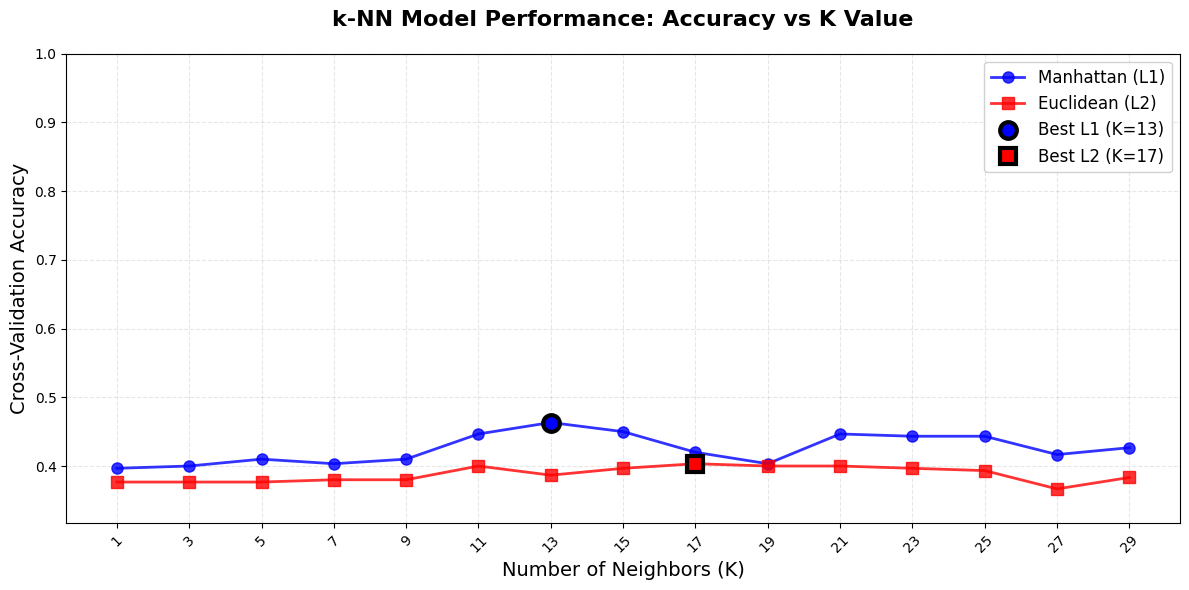

In [44]:
avg_l1 = np.mean(results['l1'], axis=1)
avg_l2 = np.mean(results['l2'], axis=1)

print("K\tL1\tL2")
print("-"*25)
for i, k in enumerate(K_values):
    print(f"{k}\t{avg_l1[i]:.4f}\t{avg_l2[i]:.4f}")

best_l1_idx = np.argmax(avg_l1)
best_l2_idx = np.argmax(avg_l2)

print(f"\nBest L1: K={K_values[best_l1_idx]}, Acc={avg_l1[best_l1_idx]:.4f}")
print(f"Best L2: K={K_values[best_l2_idx]}, Acc={avg_l2[best_l2_idx]:.4f}")

plt.figure(figsize=(12, 6))

plt.plot(K_values, avg_l1, 'o-', color='blue', linewidth=2, 
         markersize=8, label='Manhattan (L1)', alpha=0.8)
plt.plot(K_values, avg_l2, 's-', color='red', linewidth=2, 
         markersize=8, label='Euclidean (L2)', alpha=0.8)

plt.plot(K_values[best_l1_idx], avg_l1[best_l1_idx], 'o', 
         color='blue', markersize=12, markeredgewidth=3, 
         markeredgecolor='black', label=f'Best L1 (K={K_values[best_l1_idx]})')
plt.plot(K_values[best_l2_idx], avg_l2[best_l2_idx], 's', 
         color='red', markersize=12, markeredgewidth=3, 
         markeredgecolor='black', label=f'Best L2 (K={K_values[best_l2_idx]})')


plt.xlabel('Number of Neighbors (K)', fontsize=14)
plt.ylabel('Cross-Validation Accuracy', fontsize=14)
plt.title('k-NN Model Performance: Accuracy vs K Value', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=12, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(K_values, rotation=45)
plt.ylim(min(min(avg_l1), min(avg_l2)) - 0.05, 1.0)

plt.tight_layout()
plt.show()


Top 5 Predictions (Validation Set):
----------------------------------------
Image 1
True: panda
Pred: panda

Image 2
True: panda
Pred: panda

Image 3
True: dog
Pred: panda

Image 4
True: cat
Pred: panda

Image 5
True: panda
Pred: panda



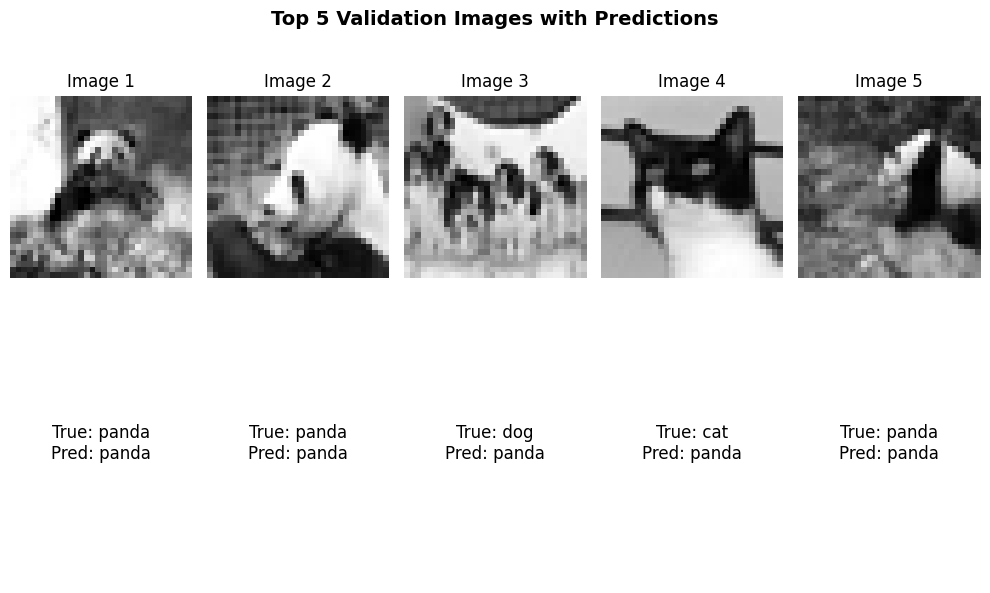

In [62]:
print("\nTop 5 Predictions (Validation Set):")
print("-" * 40)

k_best = 13 

fig, axes = plt.subplots(2, 5, figsize=(10, 6))

for i in range(5):
    actual = y_val[i]
    actual_label = label_map[actual]
    
    sample = X_val[i].reshape(1, -1)
    
    try:
        pred = predict(X_train, y_train, sample, k_best, get_l1_dist)
    except:
        try:
            pred = knn_predict(X_train, y_train, sample, k_best, distance_type='l1')
        except:
            pred = [y_train[0]]
    
    if isinstance(pred, (list, np.ndarray)):
        pred_label = label_map[pred[0]]
    else:
        pred_label = label_map[pred]
    
    print(f"Image {i+1}")
    print(f"True: {actual_label}")
    print(f"Pred: {pred_label}")
    print()
    
    ax_img = axes[0, i]
    
    if X_val[i].shape[0] == IMAGE_SIZE[0] * IMAGE_SIZE[1]:
        img_display = X_val[i].reshape(IMAGE_SIZE)
    else:
        img_display = X_val[i]
    
    ax_img.imshow(img_display, cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f"Image {i+1}", fontsize=12)
    
    ax_text = axes[1, i]
    ax_text.text(0.5, 0.5, f"True: {actual_label}\nPred: {pred_label}", 
                 ha='center', va='center', fontsize=12, 
                 transform=ax_text.transAxes)
    ax_text.axis('off')

plt.suptitle('Top 5 Validation Images with Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()